<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/04-transfer-learning/04_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning

Now, let's consider what is Transfer learning?

The idea is quite simple. First, some big tech company, which has access to virtually
infinite amounts of data and computing power, develops and trains a huge model
for their own purpose. 

Next, once it is trained, its architecture and the corresponding trained weights (the pre-trained model) are released. Finally,
everyone else can use these weights as a starting point and fine-tune them
further for a different (but similar) purpose.

That’s transfer learning in a nutshell.

##Setup

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
#from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

100% 451M/452M [00:04<00:00, 94.7MB/s]
100% 452M/452M [00:04<00:00, 95.7MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

In [ ]:
ROOT_FOLDER = "Rock-Paper-Scissors"

Since we’re using a pre-trained model, we need to use the standardization
parameters used to train the original model. 

In other words, we need to use the
statistics of the original dataset used to train that model.

So, the data preparation step for the Rock Paper Scissors dataset looks like this now:

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer = Compose([
  Resize(256),
  CenterCrop(224),
  ToTensor(),
  normalizer
])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

##Pre-Trained Model

Let's start by creating an instance of AlexNet without loading its pre-trained
weights.

In [ ]:
alex = alexnet(weights=False)
print(alex)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###Adaptive Pooling

`AdaptiveAvgPool2d` is a special kind of pooling: Instead of requiring the kernel size
(and stride), it requires the desired output size. 

In other words, whatever the
image size it gets as input, it will return a tensor with the desired size.

It gives you the freedom to use images of different sizes as inputs.

Let’s verify it.

In [ ]:
result1 = F.adaptive_avg_pool2d(torch.randn(16, 32, 32), output_size=(6, 6))
result2 = F.adaptive_avg_pool2d(torch.randn(16, 12, 12), output_size=(6, 6))

result1.shape, result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

###Loading Weights

Let’s download the weights
from a given URL, which gives you the flexibility to use pre-trained weights from
wherever you want!

In [ ]:
# URL = model_urls["alexnet"]

# ref: https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/torchvision_models.py
URL = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

In [ ]:
state_dict = load_state_dict_from_url(URL, model_dir="pretrained", progress=True)

In [ ]:
# let's load model
alex.load_state_dict(state_dict)

<All keys matched successfully>

###Model Freezing

Freezing the model means it won’t learn anymore; that is, its
parameters / weights will not be updated anymore.

What best characterizes a tensor representing a learnable parameter? It requires
gradients. 

So, if we’d like to make them stop learning anything, we need to change
exactly that:

In [ ]:
def freeze_model(model):
  for parameter in model.parameters():
    parameter.requires_grad = False

freeze_model(alex)

If the model is frozen, how I am supposed to train it for my own
purpose?

We have to unfreeze a small part of the model or, better yet,
replace a small part of the model.

###Top of the Model

The "top" of the model is loosely defined as the last layer(s) of the model, usually
belonging to its classifier part. 

The featurizer part is usually left untouched since
we’re trying to leverage the model’s ability to generate features for us.

In [ ]:
print(alex.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In our Rock Paper Scissors dataset, we have three classes. 

So, we need to replace the
output layer accordingly:

In [ ]:
alex.classifier[6] = nn.Linear(in_features=4096, out_features=3)

In [ ]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


Notice that the number of input features remains the same, since it still takes the
output from the hidden layer that precedes it. 

The new output layer requires
gradients by default, but we can double-check it:

In [ ]:
for name, param in alex.named_parameters():
  if param.requires_grad == True:
    print(name)

classifier.6.weight
classifier.6.bias


## Model Training

The configuration part is short and straightforward: We use alex model, a loss
function, and an optimizer.

In [ ]:
torch.manual_seed(17)

multi_loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer_alex = optim.Adam(alex.parameters(), lr=3e-4)

We have everything set to train the "top" layer of our modified version of AlexNet.

In [ ]:
sbs_alex = StepByStep(alex, multi_loss_fn, optimizer_alex)
sbs_alex.set_loaders(train_loader, val_loader)
sbs_alex.train(1)

Let’s see how effective transfer learning is by evaluating our model after
having trained it over one epoch only.

In [ ]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[111, 124],
        [124, 124],
        [124, 124]])

##Generating features

Well, since the frozen layers are simply generating features that will be the input
of the trainable layers, why not treat the frozen layers as such? 

We could do it in
four easy steps:

* Keep only the frozen layers in the model.
* Run the whole dataset through it and collect its outputs as a dataset of
features.
* Train a separate model (that corresponds to the "top" of the original model)
using the dataset of features.
* Attach the trained model to the top of the frozen layers.

This way, we’re effectively splitting the feature extraction and actual training
phases, thus avoiding the overhead of generating features over and over again for
every single forward pass.

To keep only the frozen layers, we need to get rid of the "top" of the original model.


But, since we also want to attach our new layer to the whole model after training,
it is a better idea to simply replace the "top" layer with an identity layer instead of
removing it entirely:

In [ ]:
alex.classifier[6] = nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


This way, the last effective layer is still `classifier.5`, which will produce the
features we’re interested in. We have a feature extractor in our hands now! 

Let’s use it to pre-process our dataset.

In [ ]:
def preprocessed_dataset(model, loader, device=None):
  if device is None:
    device = next(model.parameters()).device

  features = None
  labels = None

  for i, (x, y) in enumerate(loader):
    model.eval()
    x = x.to(device)
    output = model(x)
    if i == 0:
      features = output.detach().cpu()
      labels = y.cpu()
    else:
      features = torch.cat([features, output.detach().cpu()])
      labels = torch.cat([labels, y.cpu()])

  dataset = TensorDataset(features, labels)
  return dataset

In [ ]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

We can also save these tensors to disk:

In [ ]:
torch.save(train_preproc.tensors, "rps_preproc.pth")
torch.save(val_preproc.tensors, "rps_val_preproc.pth")

This way, they can be used to build datasets later:

In [ ]:
x, y = torch.load("rps_preproc.pth")

train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load("rps_val_preproc.pth"))

The last step of data preparation, as usual, is the creation of the data loader:

In [ ]:
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

The model has only one layer, which matches the one we used in the "Top of the
Model" subsection. 

The rest of the model configuration part remains unchanged:

In [ ]:
torch.manual_seed(17)

top_model = nn.Sequential(nn.Linear(4096, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

Let's train the model above using the
pre-processed dataset.

In [ ]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

Now we can attach the trained model to the top of the full (frozen) model:

In [ ]:
sbs_alex.model.classifier[6] = top_model
print(sbs_alex.model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
  )
)


Let’s see how it performs on the validation set.

We’re using the full model again, so we should use the original
dataset instead of the pre-processed one.

In [ ]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[109, 124],
        [124, 124],
        [124, 124]])

It is almost the same result as before.

So this show you how to use
transfer learning and how you can pre-process your dataset to speed up model
training.

##Auxiliary Classifiers

The first version of the Inception model introduced
auxiliary classifiers; that is, side-heads attached to intermediate parts of the
model that would also try to perform classification, independently from the typical
main classifier at the very end of the network.

The technique was originally developed to mitigate the vanishing gradients
problem, but it was later found that the auxiliary
classifiers were more likely to have a regularizer effect instead.

First, we load the pre-trained model, freeze its layers, and replace the layers for
both main and auxiliary classifiers:

In [ ]:
model = inception_v3(pretrained=True)
freeze_model(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 50.0MB/s]


In [ ]:
print(model.AuxLogits)

InceptionAux(
  (conv0): BasicConv2d(
    (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): BasicConv2d(
    (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=768, out_features=1000, bias=True)
)


In [ ]:
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
torch.manual_seed(42)

model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)

Unfortunately, we cannot use the standard cross-entropy loss because the
Inception model outputs two tensors, one for each classifier (although it is possible
to force it to return only the main classifier by setting its aux_logits argument to
False). 

But we can create a simple function that can handle multiple outputs,
compute the corresponding losses, and return their total:

In [ ]:
def inception_loss(outputs, labels):
  try:
    main, aux = outputs
  except ValueError:
    main = outputs
    aux = None
    loss_aux = 0

  multi_loss_fn = nn.CrossEntropyLoss(reduction="mean")
  loss_main = multi_loss_fn(main, labels)
  if aux is not None:
    loss_aux = multi_loss_fn(aux, labels)
  return loss_main + 0.4 * loss_aux

In [ ]:
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_inception = StepByStep(model, inception_loss, optimizer_model)

>Wait, aren’t we pre-processing the dataset this time?

Unfortunately, no. The `preprocessed_dataset()` function cannot handle multiple
outputs.

The Inception model is also different from the others in its expected input size: 299
instead of 224. 

So, we need to recreate the data loaders accordingly:

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer = Compose([
  Resize(299),
  ToTensor(),
  normalizer
])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

We’re ready, so let’s train our model for a single epoch and evaluate the result:

In [ ]:
sbs_inception.set_loaders(train_loader, val_loader)
sbs_inception.train(1)

In [ ]:
StepByStep.loader_apply(val_loader, sbs_inception.correct)

tensor([[110, 124],
        [ 88, 124],
        [116, 124]])

##1x1 Convolutions

The idea of a kernel of size one-by-one is somewhat counterintuitive at first. For a
single channel, this kernel is only scaling the values of its input and nothing else.

But everything changes if you have multiple channels.

A filter has as many channels as its input.
This means that each channel will be scaled independently and the results will be
added up, resulting in one channel as output(per filter).

>A `1x1` convolution can be used to reduce the number of
channels; that is, it may work as a dimension-reduction layer.

A filter using a `1x1` convolution corresponds to a weighted
average of the input channels.

In other words, a `1x1` convolution is a linear combination of the
input channels, computed pixel by pixel.

Performing a `1x1` convolution is akin to
applying a linear layer to each individual pixel over its channels.

>This is the reason why a `1x1` convolution is said to be equivalent
to a fully connected (linear) layer.

Let's see that grayscale images can be computed using a linear combination of the red,
green, and blue channels of colored images. 

So, we can convert an image to
grayscale using a `1x1` convolution!

In [ ]:
scissors = Image.open(f"{ROOT_FOLDER}/train/scissors/scissors01-001.png")
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)

weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(1, 3, 1, 1)
convolved = F.conv2d(input=image, weight=weights)

converted = ToPILImage()(convolved[0])
grayscale = scissors.convert("L")

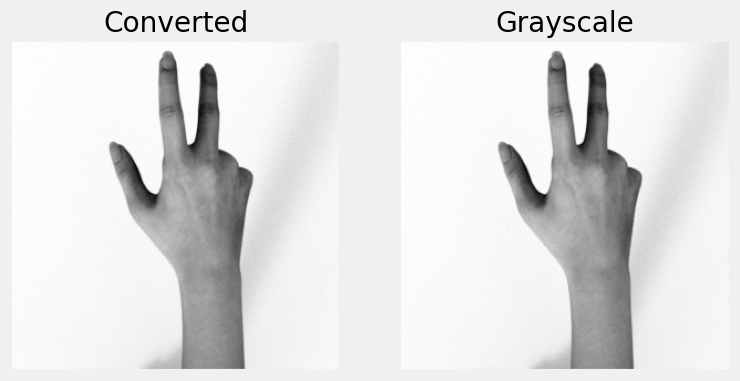

In [ ]:
fig = compare_grayscale(converted, grayscale)

You can think of converting colored images to grayscale as reducing the
dimensions of the image, since the size of the output is one-third of the input size
(one instead of three channels). 

This translates into having three times fewer
parameters in the layer that is receiving it as its own input, and it allows the
networks to grow deeper (and wider).

##Inception Modules

Inception module with dimension-reduction layers uses
1x1 convolutions to:

* reduce the number of input channels for both `3x3` and `5x5` convolution
branches; and
* reduce the number of output channels for the max pooling branch.

The `3x3` and `5x5` convolution branches may still output many channels (one for each filter), but each filter is convolving a reduced number of input channels.

Let’s see what the Inception module looks like in code.

In [ ]:
class Inception(nn.Module):
  def __init__(self, in_channels):
    super(Inception, self).__init__()

    # in_channels@HxW -> 2@HxW
    self.branch1x1_1 = nn.Conv2d(in_channels, 2, kernel_size=1)

    # in_channels@HxW -> 2@HxW -> 3@HxW
    self.branch3x3_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
    self.branch3x3_2 = nn.Conv2d(2, 3, kernel_size=3, padding=1)

    # in_channels@HxW -> 2@HxW -> 3@HxW
    self.branch5x5_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
    self.branch5x5_2 = nn.Conv2d(2, 3, kernel_size=5, padding=2)

    # in_channels@HxW -> in_channels@HxW -> 1@HxW
    self.branch_pool_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
    self.branch_pool_2 = nn.Conv2d(in_channels, 2, kernel_size=1)

  def forward(self, x):
    # Produces 2 channels
    branch1x1 = self.branch1x1_1(x)

    # Produces 3 channels
    branch3x3 = self.branch3x3_1(x)   # Dimension reduction with 1x1 convolution
    branch3x3 = self.branch3x3_2(branch3x3)

    # Produces 3 channels
    branch5x5 = self.branch5x5_1(x)   # Dimension reduction with 1x1 convolution
    branch5x5 = self.branch5x5_2(branch5x5)

    # Produces 2 channels
    branch_pool = self.branch_pool_1(x)
    branch_pool = self.branch_pool_2(branch_pool)  # Dimension reduction with 1x1 convolution

    # Concatenates all channels together (10)
    outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)
    return outputs

What if we run our example image (scissors, in the color version) through the
Inception module?

In [ ]:
inception = Inception(in_channels=3)
output = inception(image)
output.shape

torch.Size([1, 10, 300, 300])

There we go: The output has the expected ten channels.

##Batch Normalization

The need for normalization layers in order to
prevent (or mitigate) an issue commonly called "internal covariate shift," which is
just fancy for having different distributions of activation values in different layers.

In general, we would like to have all layers produce activation values with similar
distributions, ideally with zero mean and unit standard deviation.

For a mini-batch of `n` data points, given one particular feature `x`, batch
normalization will first compute the statistics for that mini-batch:

$$
\Large
\overline{X} = \frac{1}{n}\sum_{i=1}^n{x_i}
\\
\Large
\sigma(X) = \sqrt{\frac{1}{n}\sum_{i=1}^n{(x_i - \overline{X})^2}}
$$

Then, it will use these statistics to standardize each data point in the mini-batch:

$$
\Large
\text{standardized }x_i = \frac{x_i-\overline{X}}{\sigma(X)+ \epsilon}
$$

The actual difference is the optional affine transformation at the end:

$$
\Large
\text{batch normed }x_i = b + w \text{ standardized }x_i
$$

Although I’ve chosen the familiar `b` and `w `to represent these parameters, so it becomes even more clear there is
nothing special to this transformation, you’ll find them represented as `beta` and
`gamma`, respectively, in the literature.

Moreover, the terms may appear in a
different order, like this:

$$
\Large
\text{batch normed }x_i = \text{standardized }x_i\ \gamma + \beta
$$

###Running Statistics

Since batch normalization computes statistics on mini-batches, and mini-batches
contain a small number of points, these statistics are likely to fluctuate a lot. The
smaller the mini-batches, the more the statistics will fluctuate.

During the evaluation phase (or when the model is already trained and deployed),
there are no mini-batches. It is perfectly natural to feed the model a single input to
get its prediction. 

Clearly, there are no statistics for a single data point: It is its own
mean, and the variance is zero. 

How can you standardize that? You can’t!

What about keeping track of running statistics (that is, moving averages of the
statistics)? 

It is a good way of smoothing the fluctuations.

Let’s see it in action using code—we’ll use a dummy dataset with 200 random data
points and two features:

In [ ]:
torch.manual_seed(23)

dummy_points = torch.randn((200, 2)) + torch.randn((200, 2)) * 2
dummy_labels = torch.randint(2, (200, 1))

dummy_dataset = TensorDataset(dummy_points, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)